In [1]:
import numpy as np
def read_bin(file):
    cols = ['t','intensity','id','x','y','z','azimuth','range','pid']
    dtypes = ['int64', 'uint8', 'uint8','float32', 'float32', 'float32','float32', 'float32', 'int32']
    bintype = np.dtype(dict(names=cols, formats=dtypes))
    df = np.fromfile(file, bintype)
    pc = np.vstack([ df['x'], df['y'], df['z'] ]).T
    return pc
sample = read_bin('C:/Users/varun/OneDrive/Desktop/sydney-urban-objects-dataset/objects/4wd.1.2446.bin')

In [2]:
labels = {'4wd': 0, 
              'bench': 1, 
              'bicycle': 2, 
              'biker': 3, 
              'building': 4, 
              'bus': 5, 
              'car': 6, 
              'cyclist': 7, 
              'excavator': 8, 
              'pedestrian': 9, 
              'pillar': 10, 
              'pole': 11, 
              'post': 12, 
              'scooter': 13, 
              'ticket_machine': 14, 
               'traffic_lights': 15, 
              'traffic_sign': 16, 
              'trailer': 17, 
              'trash': 18, 
              'tree': 19, 
              'truck': 20, 
              'trunk': 21, 
              'umbrella': 22, 
              'ute': 23, 
              'van': 24, 
              'vegetation': 25}

num_of_classes = len(labels.keys())
num_of_classes

26

In [3]:
from torch.utils.data import Dataset, DataLoader
import glob
import time
import random
def sub_sample(pcs, labels, k):    
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis= 1)
    res = np.asarray(random.choices(res1, weights=None, cum_weights=None, k=k))
    pcs = res[:, 0:-1]
    labels = res[:, -1]
    labels -= 1
    return pcs, labels

In [4]:
class SydneyUrban(Dataset):
    def __init__(self, transform=False):
        self.files = []
        self.labels = []
        self.sample_size =  50
        folders = glob.glob("C:/Users/varun/OneDrive/Desktop/sydney-urban-objects-dataset/objects")
        files = glob.glob(folders[0] + "/*")
        for file in files:
            file_name = file.split("/")[-1]
            obj_name=file_name[8:]
            if obj_name.split(".")[-1] == "bin":
                label = obj_name.split(".")[0]
                self.labels.append(labels[label])
                self.files.append(file) 
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        pts_path = self.files[idx]
        label = self.labels[idx]
        pts = read_bin(pts_path)
        label = [label]*len(pts)
        label = np.array(label)
        pts, label = sub_sample(pts, label, self.sample_size)
        label = label[0]+1
        return {'points': np.array(pts, dtype="float32"), 'labels': label.astype(int)}

In [5]:
import torch

In [6]:
train_dataset = SydneyUrban()
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
print("Data Shapes: ", next(iter(train_loader))['points'].shape, next(iter(train_loader))['labels'].shape)
indices = torch.randperm(len(train_dataset)).tolist()
train_data = torch.utils.data.Subset(train_dataset, indices[0:-170])
val_data = torch.utils.data.Subset(train_dataset, indices[-170:])
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=0)

Data Shapes:  torch.Size([64, 50, 3]) torch.Size([64])


In [7]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
    def forward(self, input):
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix

In [8]:
class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        xb = F.relu(self.bn1(self.conv1(xb)))
        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

In [9]:
class PointNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, num_of_classes)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [10]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
pointnet = PointNet()
pointnet.to(device);
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

cpu


In [15]:
def train(model, train_loader, val_loader=None,  epochs=98, save=True):
    metrics = {'train_accuracy': [], 'val_accuracy': []}
    for epoch in range(epochs): 
        pointnet.train()
        tick = time.time()
        print('Epoch ', epoch+1, ':')
        train_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['points'].to(device), data['labels'].to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print('Train Loss: ', train_loss/len(train_loader))
        pointnet.eval()
        correct = total = 0
        with torch.no_grad():
            for data in train_loader:
                inputs, labels = data['points'].to(device), data['labels'].to(device)
                outputs, __, __ = pointnet(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        print('Train accuracy: %d %%' % train_acc)
        metrics['train_accuracy'].append(train_acc)
        correct = total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data['points'].to(device), data['labels'].to(device)
                outputs, __, __ = pointnet(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        print('Val accuracy: %d %%' % val_acc)
        tock = time.time()
        print('Time Elapsed: ', tock-tick, ' seconds')
        metrics['val_accuracy'].append(val_acc)
    torch.save(model.state_dict(), "./final_model")
    return metrics

In [16]:
metrics = train(pointnet, train_loader, val_dataloader)

Epoch  1 :
Train Loss:  0.6911521077156066
Train accuracy: 78 %
Val accuracy: 74 %
Time Elapsed:  10.465956687927246  seconds
Epoch  2 :
Train Loss:  0.6882194519042969
Train accuracy: 79 %
Val accuracy: 80 %
Time Elapsed:  10.391261339187622  seconds
Epoch  3 :
Train Loss:  0.7124308943748474
Train accuracy: 79 %
Val accuracy: 81 %
Time Elapsed:  10.171471118927002  seconds
Epoch  4 :
Train Loss:  0.7036020815372467
Train accuracy: 78 %
Val accuracy: 79 %
Time Elapsed:  10.212089538574219  seconds
Epoch  5 :
Train Loss:  0.742148494720459
Train accuracy: 83 %
Val accuracy: 75 %
Time Elapsed:  10.229212760925293  seconds
Epoch  6 :
Train Loss:  0.7117315262556076
Train accuracy: 83 %
Val accuracy: 79 %
Time Elapsed:  10.243405103683472  seconds
Epoch  7 :
Train Loss:  0.7161445379257202
Train accuracy: 79 %
Val accuracy: 76 %
Time Elapsed:  10.20499873161316  seconds
Epoch  8 :
Train Loss:  0.7216160535812378
Train accuracy: 80 %
Val accuracy: 77 %
Time Elapsed:  10.193902254104614  se

Train Loss:  0.6301892071962356
Train accuracy: 83 %
Val accuracy: 80 %
Time Elapsed:  10.199052095413208  seconds
Epoch  67 :
Train Loss:  0.5871767967939376
Train accuracy: 83 %
Val accuracy: 83 %
Time Elapsed:  10.212896347045898  seconds
Epoch  68 :
Train Loss:  0.5060428202152252
Train accuracy: 86 %
Val accuracy: 90 %
Time Elapsed:  10.184335470199585  seconds
Epoch  69 :
Train Loss:  0.5678746551275253
Train accuracy: 87 %
Val accuracy: 84 %
Time Elapsed:  10.206739664077759  seconds
Epoch  70 :
Train Loss:  0.5850383013486862
Train accuracy: 86 %
Val accuracy: 85 %
Time Elapsed:  10.226873874664307  seconds
Epoch  71 :
Train Loss:  0.5699284791946411
Train accuracy: 86 %
Val accuracy: 85 %
Time Elapsed:  10.22788143157959  seconds
Epoch  72 :
Train Loss:  0.5126413583755494
Train accuracy: 87 %
Val accuracy: 85 %
Time Elapsed:  10.354505777359009  seconds
Epoch  73 :
Train Loss:  0.5049014806747436
Train accuracy: 86 %
Val accuracy: 86 %
Time Elapsed:  10.303201675415039  secon

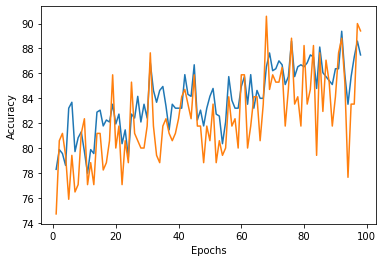

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(metrics['train_accuracy']) + 1), metrics['train_accuracy'])
plt.plot(range(1, len(metrics['val_accuracy']) + 1), metrics['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [19]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load("./final_model"))
pointnet.eval()

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

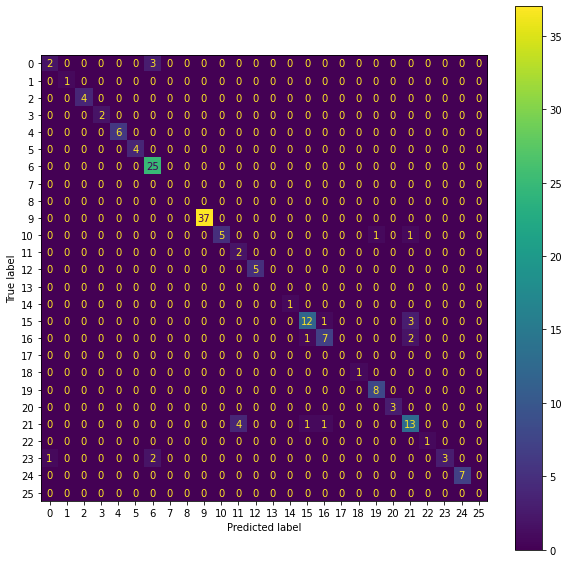

In [20]:
preds, actuals = [], []
for batch in (val_dataloader):
    pred = pointnet(batch['points'].transpose(1,2))
    actual = batch['labels']
    pred_np = np.array(torch.argmax(pred[0],1))
    preds.extend(pred_np)
    actuals.extend(actual)  
for i, _ in enumerate(actuals):
    actuals[i] = int(actuals[i])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actuals, preds, labels=list(labels.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

In [21]:
features = []
labels = []
for data in train_dataset:
    features.append(data['points'])
    labels.append(data['labels'])
features = np.array(features)
print(features[0])
labels = np.array(labels)
print(labels[0])

[[2.29429    3.5905054  1.4991498 ]
 [3.1728435  4.2467623  1.4288746 ]
 [2.778211   3.9968188  1.4429077 ]
 [2.3304129  3.4655921  1.5151082 ]
 [5.62501    2.5393412  1.6191146 ]
 [2.2208638  3.625043   1.5429586 ]
 [3.4033353  2.2799966  1.2519398 ]
 [5.5866127  3.2847939  0.7378592 ]
 [3.853987   2.7864883  1.0180913 ]
 [3.0669012  2.584261   1.5993655 ]
 [2.8070407  2.5750625  1.6048782 ]
 [3.003637   3.6684527  1.4045568 ]
 [3.5386655  2.601148   1.499218  ]
 [3.92809    2.5389647  1.8712584 ]
 [2.583757   2.811708   1.4804087 ]
 [3.1570404  2.693866   1.4147655 ]
 [2.9601371  3.5262492  1.4114065 ]
 [3.1923661  2.6574054  1.4605163 ]
 [5.5223303  2.489555   1.7403085 ]
 [3.458512   2.712732   1.2532078 ]
 [2.3684404  2.9090245  1.4936293 ]
 [3.1828752  4.110763   1.4006631 ]
 [2.2686486  2.9702008  1.526368  ]
 [3.0436187  3.1485243  1.4177215 ]
 [4.1956353  2.8471541  0.9095363 ]
 [2.778211   3.9968188  1.4429077 ]
 [3.0751035  2.6589267  1.4286608 ]
 [3.5007305  2.5778832  1.53

In [22]:
labels.shape

(631,)

In [23]:
features[0]

array([[2.29429   , 3.5905054 , 1.4991498 ],
       [3.1728435 , 4.2467623 , 1.4288746 ],
       [2.778211  , 3.9968188 , 1.4429077 ],
       [2.3304129 , 3.4655921 , 1.5151082 ],
       [5.62501   , 2.5393412 , 1.6191146 ],
       [2.2208638 , 3.625043  , 1.5429586 ],
       [3.4033353 , 2.2799966 , 1.2519398 ],
       [5.5866127 , 3.2847939 , 0.7378592 ],
       [3.853987  , 2.7864883 , 1.0180913 ],
       [3.0669012 , 2.584261  , 1.5993655 ],
       [2.8070407 , 2.5750625 , 1.6048782 ],
       [3.003637  , 3.6684527 , 1.4045568 ],
       [3.5386655 , 2.601148  , 1.499218  ],
       [3.92809   , 2.5389647 , 1.8712584 ],
       [2.583757  , 2.811708  , 1.4804087 ],
       [3.1570404 , 2.693866  , 1.4147655 ],
       [2.9601371 , 3.5262492 , 1.4114065 ],
       [3.1923661 , 2.6574054 , 1.4605163 ],
       [5.5223303 , 2.489555  , 1.7403085 ],
       [3.458512  , 2.712732  , 1.2532078 ],
       [2.3684404 , 2.9090245 , 1.4936293 ],
       [3.1828752 , 4.110763  , 1.4006631 ],
       [2.

In [24]:


features.shape
labels.shape

(631,)

In [29]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test= X_test.reshape(X_test.shape[0], -1)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)


DecisionTreeClassifier()

In [30]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.3779527559055118


In [31]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test= X_test.reshape(X_test.shape[0], -1)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)



In [32]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.3937007874015748


In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.2755905511811024


In [34]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:", logreg.score(X_test, y_test))

Accuracy: 0.3464566929133858


C:\Users\varun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Accuracy:", nb.score(X_test, y_test))

Accuracy: 0.18110236220472442


In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", rf.score(X_test, y_test))


Accuracy: 0.5275590551181102


In [37]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.33858267716535434
